In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import copy
import seaborn as sn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch import Tensor
from torch.utils import data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision import models

from os.path import isdir, join
from typing import Optional, Type, Union, List, Dict
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

torchvision.transform: image preprocessing methods: Normalize, augmentation, ...

torchvision.datasets: data sets, ex: mnist, CIFAR-10, ...

torchvision.models: pretrained models, ex: AlexNet, VGG, ResNet, ...

In [35]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


## Step 0: Show Data

In [3]:
train_image = pd.read_csv('train_img.csv')
train_label = pd.read_csv('train_label.csv')
test_image = pd.read_csv('test_img.csv')
test_label = pd.read_csv('test_label.csv')

In [4]:
np.squeeze(train_image.values), np.squeeze(train_label.values)

(array(['6592_left', '30349_right', '1741_right', ..., '38060_left',
        '35445_right', '5858_left'], dtype=object),
 array([0, 3, 0, ..., 0, 2, 0]))

In [5]:
image = img.imread(join("./data",np.squeeze(train_image.values)[0]) + ".jpeg")
image.shape

(512, 512, 3)

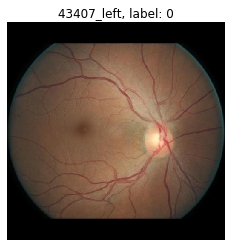

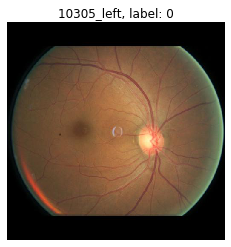

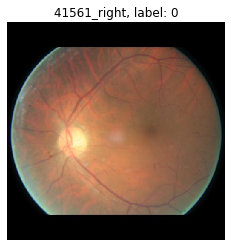

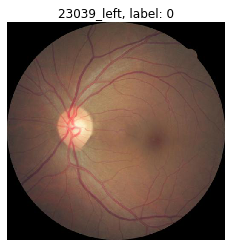

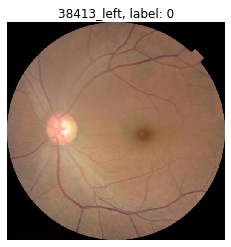

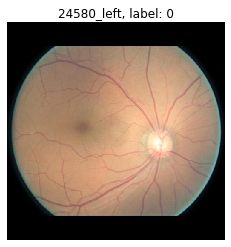

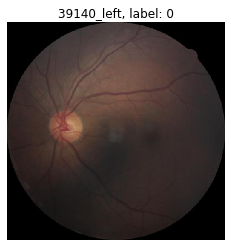

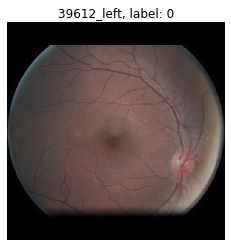

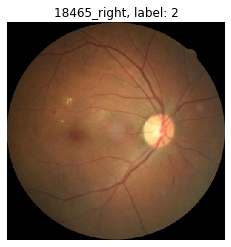

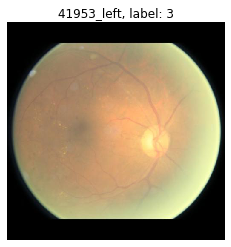

In [6]:
Path = "./data"
allFileList = os.listdir(Path)

cnt = 10
for file in allFileList:
    # print(os.path.join(Path, file))
    image_name = os.path.splitext(file)[0]
#     print(image_name)
    
    
    if image_name in list(np.squeeze(train_image.values)):
        image_idx = list(np.squeeze(train_image.values)).index(image_name)
        image_label = str(np.squeeze(train_label.values)[image_idx])
    
    elif image_name in list(np.squeeze(test_image.values)):
        image_idx = list(np.squeeze(test_image.values)).index(image_name)
        image_label = str(np.squeeze(test_label.values)[image_idx])
    
    else:
        image_label = 'N/A'
        
    
    image = img.imread(os.path.join(Path, file))
    plt.axis('off')
    plt.title(image_name + ", label: " + image_label)
    plt.imshow(image)
    plt.show()
    
    cnt -= 1
    if cnt == 0:
        break

0 - No DR

1 - Mild (輕微)

2 - Moderate (緩和)

3 - Severe (嚴重)

4 - Proliferative DR (增生)

# Step 1: Data Loader

## Read csv

In [7]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)

transforms.Compose
1. CenterCrop
2. RandomCrop
3. RandomResizedCrop
4. RandomHorizontalFlip
5. RandomVerticalFlip
6. RandomRotation
7. Pad
8. Resize
9. Normalize
10. ToTensor
11. ColorJitter (modify brightness, contrast, saturation or hue)
12. Grayscale
13. RandomGrayscale
14. RandomAffine
...

Ref:

https://ithelp.ithome.com.tw/articles/10275928?sc=iThomeR

https://ithelp.ithome.com.tw/articles/10276641


## Data Augmentation

In [8]:
def custom_transform(mode):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    # Transformer
    if mode == 'train':
        transformer = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            normalize
        ])
    else:
        transformer = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])

    return transformer

Why Pytorch officially use mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] to normailize images?

They are calculated based on millions of images. If you want to train from scratch on your own dataset, you can calculate the new mean and std.

Ref:
1. https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
2. https://yanwei-liu.medium.com/pytorch%E8%A8%88%E7%AE%97dataset%E7%9A%84mean%E5%92%8Cstd-ecadb63420ca

In [9]:
class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)
            transform: data augmentation
            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode) # read csv
        self.mode = mode # train or test
        self.transform = custom_transform(mode=mode) # data augmentation

        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        path = os.path.join(self.root, self.img_name[index] + '.jpeg')
        img = self.transform(Image.open(path).convert('RGB'))
        label = self.label[index]

        return img, label

# Step 2: Build Model (ResNet18 & ResNet50)

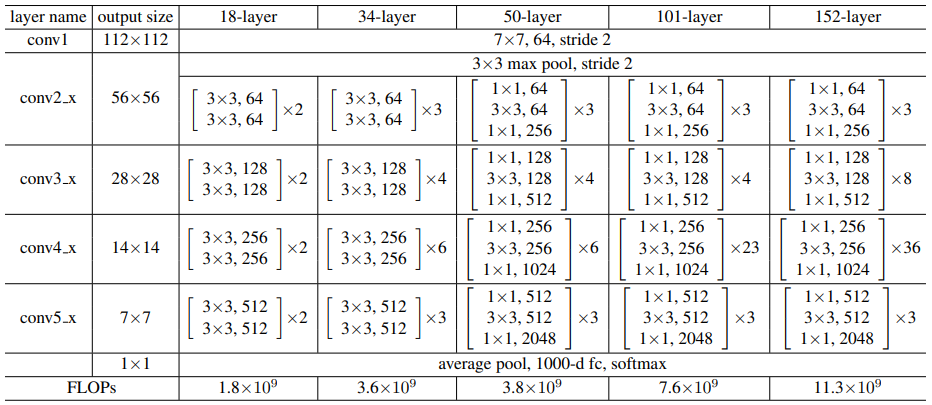

## Basic Block

resnet18, resnet34, resnet50, resnet101, resnet152

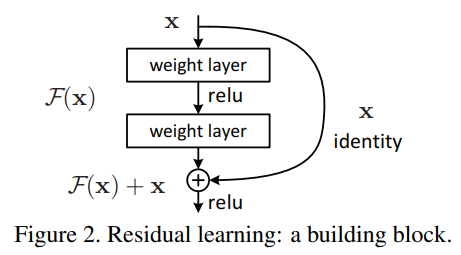

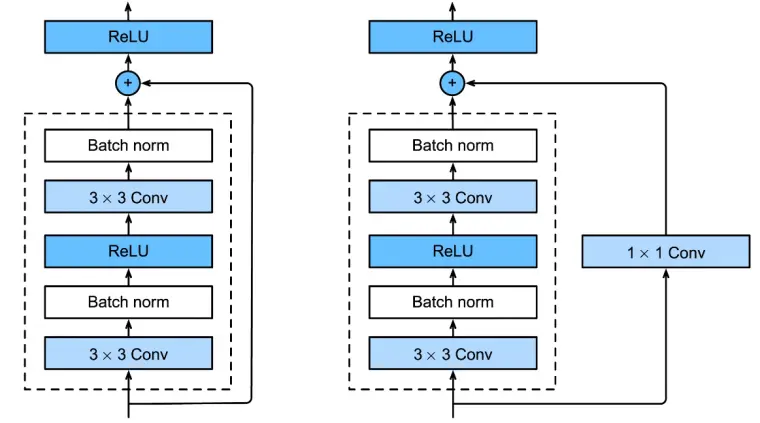

expansion = last_block_channel/first_block_channel

expansion = 1: Do not change the number of channels

expansion = 4: Will change the number of channels

In [10]:
class BasicBlock(nn.Module):
    """
    output = (channels, H, W) -> conv2d (3x3) -> (channels, H, W) -> conv2d (3x3) -> (channels, H, W) + (channels, H, W)
    """
    
    expansion: int = 1 # expansion = last_block_channel/first_block_channel
    # In ResNet, each block has an expansion parameter in order to increase the out_channels if needed.
    
    def __init__(self, in_channels, out_channels, stride=1, down_sample: Optional[nn.Module] = None):
        super(BasicBlock, self).__init__()
    
        self.activation = nn.ReLU(inplace=True) 
        # inplace=True: Modify the tensor passed from the upper-layer network Conv2d directly
        #              , which can save computing memory without storing other variables.
        
        
        self.block = nn.Sequential(
            ############ 3x3 Conv ############
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False),
            
            ########### Batch norm ###########
            nn.BatchNorm2d(out_channels),
            
            ############## ReLU ##############
            self.activation,
            
            ############ 3x3 Conv ############
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                bias=False),
            
            ########### Batch norm ###########
            nn.BatchNorm2d(out_channels),
            
        )
        self.down_sample = down_sample # shortcut
        
        
    def forward(self, inputs: TensorDataset) -> Tensor:
        """
        Forward propagation
        :param inputs: input data
        :return: results
        """
        residual = inputs
        outputs = self.block(inputs)
        if self.down_sample is not None: # when shortcut is exist 
            residual = self.down_sample(inputs)
        
        outputs = self.activation(outputs + residual)
        
        return outputs

## Bottleneck Block

 resnet50, resnet101, resnet152

### Deeper Bottleneck Architectures 
Because of concerns on the training time that we can afford, we modify the building blockas a bottleneck design.

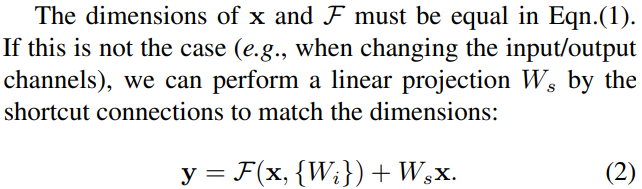

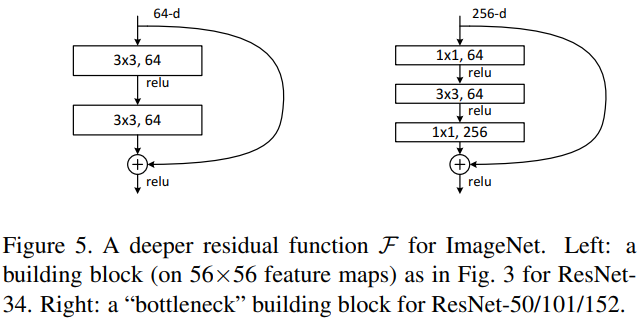

expansion = last_block_channel/first_block_channel = 4

If our input depth is 64, then it becomes 256 after expanding by 4 times.

Goal: match the dimensions

In [11]:
class BottleneckBlock(nn.Module):
    """
    output = (channels * 4, H, W) -> conv2d (1x1) -> (channels, H, W) -> conv2d (3x3) -> (channels, H, W)
            -> conv2d (1x1) -> (channels * 4, H, W) + (channels * 4, H, W)
    
    """
    expansion: int = 4 # expansion=last_block_channel/first_block_channel
        
    def __init__(self, in_channels, out_channels, stride=1, down_sample: Optional[nn.Module] = None):
        super(BottleneckBlock, self).__init__()
        
        external_channels = out_channels * self.expansion
        self.activation = nn.ReLU(inplace=True)
        
        self.block = nn.Sequential(
            ############ 1x1 Conv ############
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=1,
                      bias=False),

            ########### Batch norm ###########
            nn.BatchNorm2d(out_channels),

            ############## ReLU ##############
            self.activation,

            ############ 3x3 Conv ############
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=stride,
                      padding=1,
                      bias=False),

            ########### Batch norm ###########
            nn.BatchNorm2d(out_channels),

            ############## ReLU ##############
            self.activation,

            ############ 1x1 Conv ############
            nn.Conv2d(in_channels=out_channels,
                      out_channels=external_channels,
                      kernel_size=1,
                      bias=False),

            ########### Batch norm ###########
            nn.BatchNorm2d(external_channels),
        )
        self.down_sample = down_sample
        

    def forward(self, inputs: TensorDataset) -> Tensor:
        """
        Forward propagation
        :param inputs: input data
        :return: results
        """

        residual = inputs
        outputs = self.block(inputs)

        if self.down_sample is not None:
            residual = self.down_sample(inputs)

        outputs = self.activation(outputs + residual)

        return outputs
        
        
        

In [12]:
class ResNet(nn.Module):
    def __init__(self, architecture: str, block: Type[Union[BasicBlock, BottleneckBlock]], layers: List[int]):
        super(ResNet, self).__init__()
        
        self.current_channels = 64
        
        #################### conv_1 ####################
        # Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1)
        )

        #################### conv_2 ####################
        # stride = 1, do not change img size
        self.conv_2 = self.make_layer(block=block,
                                      num_of_blocks=layers[0],
                                      in_channels=64)
        
        #################### conv_3 ####################
        # stride = 2, need to build downsample layer
        self.conv_3 = self.make_layer(block=block,
                                      num_of_blocks=layers[1],
                                      in_channels=128,
                                      stride=2)
        #################### conv_4 ####################
        # stride = 2, need to build downsample layer
        self.conv_4 = self.make_layer(block=block,
                                      num_of_blocks=layers[2],
                                      in_channels=256,
                                      stride=2)
        
        #################### conv_5 ####################
        # stride = 2, need to build downsample layer
        self.conv_5 = self.make_layer(block=block,
                                      num_of_blocks=layers[3],
                                     in_channels=512,
                                     stride=2)
        
        ############ AdaptiveAvgPool2d & fc ############
        self.classify = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=512 * block.expansion, out_features=50),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25), # 25% chance of an element of input tensor to be zeroed
            nn.Linear(in_features=50, out_features=5)
        )

    def make_layer(self, block: Type[Union[BasicBlock, BottleneckBlock]], num_of_blocks: int, in_channels: int,
                   stride: int = 1) -> nn.Sequential:
        """
        Make a layer with given block
        :param block: block to be used to compose the layer
        :param num_of_blocks: number of blocks in this layer
        :param in_channels: channels used in the blocks
        :param stride: stride
        :return: convolution layer composed with given block
        """
        down_sample = None
        
        # Determine whether stride is 1 and whether the input channel and output channel are equal.
        # If not equal, use 1x1 convolution to change size and channels
        
        if stride != 1 or self.current_channels != in_channels * block.expansion:
            down_sample = nn.Sequential(
                nn.Conv2d(in_channels=self.current_channels,
                          out_channels=in_channels * block.expansion,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(in_channels * block.expansion),
            )

        layers = [
            block(in_channels=self.current_channels,
                  out_channels=in_channels,
                  stride=stride,
                  down_sample=down_sample)
        ]
        self.current_channels = in_channels * block.expansion
        layers += [block(in_channels=self.current_channels, out_channels=in_channels) for _ in range(1, num_of_blocks)]

        return nn.Sequential(*layers)

    def forward(self, inputs: TensorDataset) -> Tensor:
        """
        Forward propagation
        :param inputs: input data
        :return: results
        """
        partial_results = inputs
        for idx in range(1, 6):
            partial_results = getattr(self, f'conv_{idx}')(partial_results)
        return self.classify(partial_results)



In [13]:
def ResNet18() -> ResNet:
    """
    Get ResNet18
    :param pretrain: whether use pretrained model
    :return: ResNet18
    """
    return ResNet(architecture='resnet18', block=BasicBlock, layers=[2, 2, 2, 2])

In [14]:
def ResNet50() -> ResNet:
    """
    Get ResNet50
    :param pretrain: whether use pretrained model
    :return: ResNet50
    """
    return ResNet(architecture='resnet50', block=BottleneckBlock, layers=[3, 4, 6, 3])

## Train

In [15]:
def split_train_test():

    root = 'data'
    train_dataloader = DataLoader(
        RetinopathyLoader(root, 'train'),
        batch_size=batch_size,
        shuffle=True
    )
    test_dataloader = DataLoader(
        RetinopathyLoader(root, 'test'),
        batch_size=batch_size,
        shuffle=False
    )

    return train_dataloader, test_dataloader

In [16]:
def train(model, SAVE_MODEL_PATH):
    torch.cuda.empty_cache()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    loss_epoch = []
    train_acc, test_acc = [], []
    best_acc = 0.0
    for epoch in range(epochs):
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss = 0.0

        model.train()
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))

        # ---------------------------
        # Training Stage
        # ---------------------------

        for i, (x, label) in enumerate(tqdm(train_dataloader)):
            x = x.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.int64)

            optimizer.zero_grad()
            # for every mini-batch during the training phase,
            # we set the gradients to zero before starting to do backpropragation
            
            outputs = model(x)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            # calculate training data accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += label.size(0)
            correct_train += (predicted == label).sum().item()
            

            train_loss += loss.item()
            iter += 1
            

        print(
            'Training epoch: %d | loss: %.3f | acc: %.3f' %
            (epoch + 1, train_loss / iter, correct_train / total_train)
        )

        # --------------------------
        # Testing Stage
        # --------------------------

        model.eval()

        for i, (x, label) in enumerate(tqdm(test_dataloader)):
            with torch.no_grad():  # don't need gradient
                x, label = x.to(device), label.to(device)
                outputs = model(x)  # predict image
                # calculate testing data accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum().item()

        valid_acc = correct_test / total_test
        print(f'Test acc: {valid_acc:.3f}')
        if valid_acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            # deep copy vs. shallow copy
            # deep copy:    Both variable and memory addresses are copied
            # shallow copy: Only the variable is copied, the memory address is not copied
            
            best_acc = valid_acc
            torch.save(best_model_wts, SAVE_MODEL_PATH)

        train_acc.append(100 * (correct_train / total_train))
        test_acc.append(100 * (correct_test / total_test))
        loss_epoch.append(train_loss / iter)
    
    return train_acc, test_acc, loss_epoch, best_acc

In [17]:
output_dir = './report_20220825_v2'

In [18]:
os.makedirs(output_dir, exist_ok=True)

In [19]:
batch_size = 16
lr = 1e-3
epochs = 5
model_name = 'resnet18'


In [20]:
train_dataloader, test_dataloader = split_train_test()

> Found 28099 images...
> Found 7025 images...


In [21]:
if model_name == 'resnet50':
    model_w = models.resnet50(pretrained=True)
else:
    model_w = models.resnet18(pretrained=True)

    
in_features = model_w.fc.in_features
model_w.fc = nn.Linear(in_features, 5)
# if model_name == 'resnet50':
#     model.load_state_dict(torch.load('checkpoint_20epochs_16bs/resnet50_pretrained.pt'))
model_w = model_w.to(device)

In [22]:
print(model_w)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
train_acc1, test_acc1, train_loss1, best_acc1 = train(model_w, f'{output_dir}/resnet{model_name[-2:]}_pretrained.pt')

  0%|          | 0/1757 [00:00<?, ?it/s]

epoch: 1 / 5


  0%|          | 1/440 [00:00<01:08,  6.36it/s]

Training epoch: 1 | loss: 0.740 | acc: 0.757


100%|██████████| 440/440 [01:14<00:00,  5.93it/s]


Test acc: 0.784


  0%|          | 0/1757 [00:00<?, ?it/s]

epoch: 2 / 5


  0%|          | 0/440 [00:00<?, ?it/s]

Training epoch: 2 | loss: 0.639 | acc: 0.790


100%|██████████| 440/440 [01:23<00:00,  5.26it/s]


Test acc: 0.794


  0%|          | 0/1757 [00:00<?, ?it/s]

epoch: 3 / 5


  0%|          | 0/440 [00:00<?, ?it/s]

Training epoch: 3 | loss: 0.602 | acc: 0.800


100%|██████████| 440/440 [01:34<00:00,  4.66it/s]


Test acc: 0.808


  0%|          | 0/1757 [00:00<?, ?it/s]

epoch: 4 / 5


  0%|          | 1/440 [00:00<01:25,  5.13it/s]

Training epoch: 4 | loss: 0.579 | acc: 0.809


  0%|          | 0/1757 [00:00<?, ?it/s]

Test acc: 0.801
epoch: 5 / 5


  0%|          | 0/440 [00:00<?, ?it/s]

Training epoch: 5 | loss: 0.561 | acc: 0.814


100%|██████████| 440/440 [01:34<00:00,  4.68it/s]


Test acc: 0.814


In [37]:
if model_name == 'resnet50':
    model_wo = ResNet50()
else:
    model_wo = ResNet18()

model_wo = model_wo.to(device)
print(model_wo)

ResNet(
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): BasicBlock(
      (activation): ReLU(inplace=True)
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (activation): ReLU(inplace=True)
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [38]:
train_acc2, test_acc2, train_loss2, best_acc2 = train(model_wo, f'{output_dir}/resnet{model_name[-2:]}_wo.pt')

  0%|          | 0/1757 [00:00<?, ?it/s]

epoch: 1 / 5


  0%|          | 1/440 [00:00<01:25,  5.13it/s]

Training epoch: 1 | loss: 0.892 | acc: 0.732


  0%|          | 0/1757 [00:00<?, ?it/s]

Test acc: 0.734
epoch: 2 / 5


  0%|          | 1/440 [00:00<01:08,  6.39it/s]

Training epoch: 2 | loss: 0.874 | acc: 0.735


  0%|          | 0/1757 [00:00<?, ?it/s]

Test acc: 0.734
epoch: 3 / 5


  0%|          | 1/440 [00:00<01:23,  5.25it/s]

Training epoch: 3 | loss: 0.865 | acc: 0.735


  0%|          | 0/1757 [00:00<?, ?it/s]

Test acc: 0.734
epoch: 4 / 5


  0%|          | 1/440 [00:00<01:23,  5.26it/s]

Training epoch: 4 | loss: 0.860 | acc: 0.735


  0%|          | 0/1757 [00:00<?, ?it/s]

Test acc: 0.734
epoch: 5 / 5


  0%|          | 1/440 [00:00<01:15,  5.83it/s]

Training epoch: 5 | loss: 0.859 | acc: 0.735


100%|██████████| 440/440 [01:16<00:00,  5.74it/s]

Test acc: 0.734


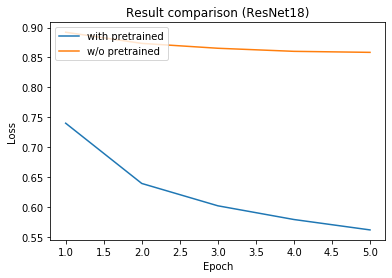

In [39]:
plt.figure()
x = np.linspace(1, epochs, epochs)
plt.plot(x, train_loss1)  # plot your loss
plt.plot(x, train_loss2)
plt.title(f'Result comparison (ResNet{model_name[-2:]})')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['with pretrained', 'w/o pretrained'], loc='upper left')
plt.savefig(os.path.join(output_dir, f'ResNet{model_name[-2:]}_loss.png'))

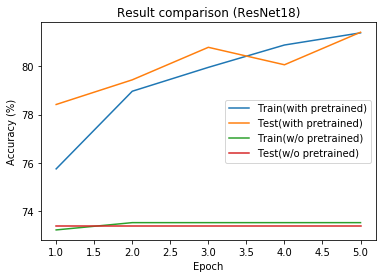

In [40]:
plt.figure()
plt.plot(x, train_acc1)  # plot your training accuracy
plt.plot(x, test_acc1)  # plot your testing accuracy
plt.plot(x, train_acc2)  
plt.plot(x, test_acc2)  
plt.title(f'Result comparison (ResNet{model_name[-2:]})')
plt.ylabel('Accuracy (%)'), plt.xlabel('Epoch')
plt.legend(['Train(with pretrained)', 'Test(with pretrained)', 'Train(w/o pretrained)', 'Test(w/o pretrained)'])
plt.savefig(os.path.join(output_dir, f'ResNet{model_name[-2:]}_acc.png'))

In [50]:
print(f'ResNet{model_name[-2:]} with pretrained test accuracy: {best_acc1}')
print(f'ResNet{model_name[-2:]} w/o pretrained test accuracy: {best_acc2}')

ResNet18 with pretrained test accuracy: 0.8142348754448399
ResNet18 w/o pretrained test accuracy: 0.7335231316725979


## Test

In [42]:
def plot_confusion_matrix(y_true, y_pred, classes=[0, 1, 2, 3, 4],
                          title=None,
                          cmap=plt.cm.Blues,
                          filename=None):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    fig, ax = plt.subplots()
    sn.heatmap(cm, annot=True, ax=ax, cmap=cmap, fmt='.2f')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=0)
    plt.title(title)
#     plt.savefig(filename, dpi=300)




In [46]:
def evaluate(model):
    correct_test, total_test = 0, 0
    labels, pred = [], []
    model.eval()
    for i, (x, label) in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():  # don't need gradient
            x, label = x.to(device), label.to(device)
            outputs = model(x)  # predict image
            # calculate testing data accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += label.size(0)
            correct_test += (predicted == label).sum().item()
            
            labels.extend(label.detach().cpu().numpy().tolist())
            pred.extend(predicted.detach().cpu().numpy().tolist())
            # detach(): creates a tensor where the storage is shared with another tensor with no grad involved
            #          (to cut off backpropagation)

    test_acc = correct_test / total_test
    print(f'Test acc: {test_acc:.3f}')
#     filename = checkpoint.split('/')[-1]
    plot_confusion_matrix(labels, pred, title=f'Normalized confusion matrix ({model_name})')

In [47]:
test_dataloader = DataLoader(
    RetinopathyLoader('data', 'test'),
    batch_size=batch_size,
    shuffle=False
)

> Found 7025 images...


100%|██████████| 440/440 [01:17<00:00,  5.71it/s]


Test acc: 0.814


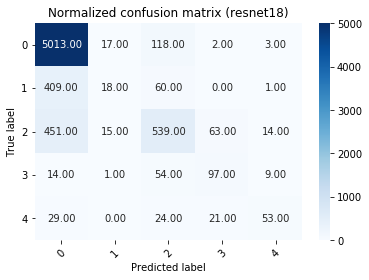

In [48]:
model_w = model_w.to(device)
evaluate(model_w)

100%|██████████| 440/440 [01:16<00:00,  5.79it/s]


Test acc: 0.734


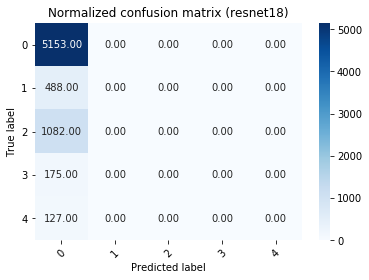

In [49]:
model_wo = model_wo.to(device)
evaluate(model_wo)